In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
from datetime import datetime
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM


from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [98]:
#load dataset
appl_stock = pd.read_csv('AAPL.csv', parse_dates=['Time'])#, engine='python', skipfooter=3)
appl_sent = pd.read_json('sentiment/appl_parse.json')
print(dataframe.head())
print (len(dataframe))



                 Time   First    Last         Time_nohour
0 2008-01-02 09:00:00  198.79  200.16 2008-01-02 09:00:00
1 2008-01-02 10:00:00  200.16  198.05 2008-01-02 10:00:00
2 2008-01-02 11:00:00  198.05  195.12 2008-01-02 11:00:00
3 2008-01-02 12:00:00  195.12  194.47 2008-01-02 12:00:00
4 2008-01-02 13:00:00  194.46  194.98 2008-01-02 13:00:00
17418


In [99]:
print(type(appl_stock['Time'][0]))
print(type(appl_sent['date'][0]))
print(appl_sent.head())

<class 'pandas.tslib.Timestamp'>
<class 'pandas.tslib.Timestamp'>
   bearish  bearish_percent  bullish  bullish_percent       date  none  total
0        0              0.0        4            100.0 2011-01-03   105    109
1        0              0.0        2            100.0 2011-01-04    59     61
2        0              0.0        1            100.0 2011-01-05    58     59
3        0              0.0        1            100.0 2011-01-06    91     92
4        0              0.0        2            100.0 2011-01-07    92     94


In [102]:
appl_stock['Time_nohour'] = appl_stock['Time'] 
appl_stock['Time_nohour'] = appl_stock['Time_nohour'].apply((lambda ts: pd.Timestamp(datetime(ts.year, ts.month, ts.day) ))) 
                                
print(appl_stock['Time_nohour'])


0       2008-01-02
1       2008-01-02
2       2008-01-02
3       2008-01-02
4       2008-01-02
5       2008-01-02
6       2008-01-02
7       2008-01-02
8       2008-01-03
9       2008-01-03
10      2008-01-03
11      2008-01-03
12      2008-01-03
13      2008-01-03
14      2008-01-03
15      2008-01-03
16      2008-01-04
17      2008-01-04
18      2008-01-04
19      2008-01-04
20      2008-01-04
21      2008-01-04
22      2008-01-04
23      2008-01-04
24      2008-01-07
25      2008-01-07
26      2008-01-07
27      2008-01-07
28      2008-01-07
29      2008-01-07
           ...    
17388   2016-09-07
17389   2016-09-07
17390   2016-09-07
17391   2016-09-07
17392   2016-09-07
17393   2016-09-07
17394   2016-09-08
17395   2016-09-08
17396   2016-09-08
17397   2016-09-08
17398   2016-09-08
17399   2016-09-08
17400   2016-09-08
17401   2016-09-08
17402   2016-09-09
17403   2016-09-09
17404   2016-09-09
17405   2016-09-09
17406   2016-09-09
17407   2016-09-09
17408   2016-09-09
17409   2016

In [163]:
dataframe = appl_stock
dataframe_merge = pd.merge(appl_stock, appl_sent, left_on='Time_nohour', right_on='date')
#print(dataframe)

In [164]:
dataset = (0.5*(dataframe['First'] + dataframe['Last'])).values
sent_dataset = dataframe_merge['bullish_percent'].values
print(dataset)

[ 199.475  199.105  196.585 ...,  105.205  105.455  105.445]


In [165]:
scaler = MinMaxScaler(feature_range=(0, 1))
sent_scaler =  MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
sent_dataset = sent_scaler.fit_transform(sent_dataset)

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

In [166]:
def rnnDataPrep(data, n_prev):
    X_data, y_data = [], []
    #naive version
    for i in range(n_prev, len(data)):#11th entry, previous 10 are kept
        X_data.append(data[i - (n_prev):i].tolist())
    
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))

def rnnDataPrepSent(data, n_prev):
    X_data, y_data = [], []
    #naive version
    for i in range(n_prev, len(data)):#11th entry, previous 10 are kept
        X_data.append(np.append(data[i - (n_prev):i], sent_dataset[i-1]) .tolist())
    
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))
    

temp_x, temp_y = rnnDataPrep(dataset, 10)
#print(temp_x)
print (temp_x.shape, temp_y.shape)


(17408, 10, 1) (17408,)


In [181]:
#Splitting data into training and validation


ttR = 0.6 #train test Ratio
#n = int(ttR * len(dataset))

lb = 5 #lb stands for look back, 
X, y = rnnDataPrep(dataset, lb)
n = int(ttR * len(X))
#train, test = X#dataset[:int(ttR * len(dataset))], dataset[int(ttR * len(dataset)):] #split chronologically

X_train, y_train = X[:n], y[:n]#rnnDataPrep(train, lb)
X_test, y_test = X[n:], y[n:]#rnnDataPrep(test, lb)


#print(train.shape, test.shape)
print(len(dataset))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


17418
(10420, 50, 1) (6948, 50, 1)
(10420,) (6948,)


In [182]:
# create and fit the LSTM network

def build_model_multilayer():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def build_model_unilayer():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=4))
    model.add(Dense(output_dim=1))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model
    
model_unilayer = build_model_unilayer()
model_unilayer.fit(X_train, y_train, nb_epoch=10, batch_size=1, verbose=2)


Compilation Time :  0.00875091552734375
Epoch 1/10
66s - loss: 0.0012
Epoch 2/10
66s - loss: 3.1844e-05
Epoch 3/10
66s - loss: 2.9220e-05
Epoch 4/10
66s - loss: 2.7272e-05
Epoch 5/10
66s - loss: 2.5529e-05
Epoch 6/10
66s - loss: 2.4187e-05
Epoch 7/10
65s - loss: 2.2866e-05
Epoch 8/10
66s - loss: 2.1538e-05
Epoch 9/10
65s - loss: 2.0717e-05
Epoch 10/10
66s - loss: 2.0019e-05


In [183]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))

trainScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_test, y_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

baseline test score = 99.90 RMSE
train score = 81.15 RMSE
test score = 85.45 RMSE


In [202]:
#PURE SENT FITTING
sent_lb = 1

X_sent, y_sent = rnnDataPrep(sent_dataset, sent_lb)[0], 0.5*(dataframe_merge['First'] + dataframe_merge['Last'])[1:]
n = int(ttR * len(X_sent))
#train, test = X_sent#dataset[:int(ttR * len(dataset))], dataset[int(ttR * len(dataset)):] #split chronologically_sent
print(len(X_sent), len(y_sent))
X_sent_train, y_sent_train = X_sent[:n], y_sent[:n]
X_sent_test, y_sent_test = X_sent[n:], y_sent[n:]


11062 11062


In [203]:
model_sent = build_model_unilayer()

model_sent.fit(X_sent_train, y_sent_train, nb_epoch=50, batch_size=1, verbose=2)

Compilation Time :  0.007627964019775391
Epoch 1/50
8s - loss: 231361.2569
Epoch 2/50
8s - loss: 207111.0270
Epoch 3/50
8s - loss: 184664.4547
Epoch 4/50
8s - loss: 163633.4807
Epoch 5/50
7s - loss: 143998.5509
Epoch 6/50
7s - loss: 125845.6603
Epoch 7/50
7s - loss: 109127.0095
Epoch 8/50
8s - loss: 93840.8922
Epoch 9/50
7s - loss: 79923.0186
Epoch 10/50
7s - loss: 67484.9643
Epoch 11/50
7s - loss: 56451.1796
Epoch 12/50
8s - loss: 46768.2151
Epoch 13/50
8s - loss: 38498.9857
Epoch 14/50
8s - loss: 31503.6361
Epoch 15/50
8s - loss: 25810.9666
Epoch 16/50
9s - loss: 21300.6429
Epoch 17/50
7s - loss: 17867.5579
Epoch 18/50
7s - loss: 15353.8566
Epoch 19/50
7s - loss: 13591.4129
Epoch 20/50
7s - loss: 12401.3569
Epoch 21/50
7s - loss: 11626.1570
Epoch 22/50
7s - loss: 11132.0916
Epoch 23/50
7s - loss: 10822.8149
Epoch 24/50
7s - loss: 10632.7043
Epoch 25/50
7s - loss: 10514.5796
Epoch 26/50
7s - loss: 10444.1672
Epoch 27/50
7s - loss: 10400.3785
Epoch 28/50
7s - loss: 10374.5415
Epoch 29/

In [204]:
#===============================================================

baseline_testScore = sent_scaler.inverse_transform(np.array([[mean_squared_error(y_sent_test[1:], y_sent_test[:-1])**.5]]))

trainScore = sent_scaler.inverse_transform(np.array([[model_sent.evaluate(X_sent_train, y_sent_train, verbose=0)**.5]]))
testScore = sent_scaler.inverse_transform(np.array([[model_sent.evaluate(X_sent_test, y_sent_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

baseline test score = 51.58 RMSE
train score = 10167.32 RMSE
test score = 37334.57 RMSE


In [172]:
# generate predictions for training
y_train_pred = model_unilayer.predict(X_train)
y_test_pred = model_unilayer.predict(X_test)

y_sent_train_pred = model_sent.predict(X_sent_train)
y_sent_test_pred = model_sent.predict(X_sent_test)

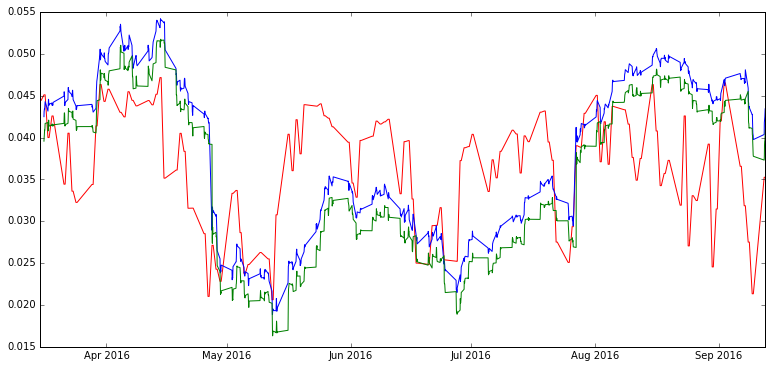

In [180]:
nn = 1000

plt.figure(figsize=(13, 6))

plt.plot(dataframe_merge['Time'][3:][-nn:], sent_dataset[3:][-nn:]/20, color='red')
#plt.plot(dataframe_merge['Time'][3:][-nn:], y_sent_test_pred[3:][-nn:]/20, color='purple')

plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], '-', ms=5, color='blue')
#plt.plot(dataframe['Time'][3:][:n], y_train_pred, 'r')
plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:], '-', ms=5, color='green')

#plt.plot(dataframe['Time'][3:][n:][-nn:], y_sent_test_pred[-nn:], '-', ms=5, color='red')